### Test robustness of VAE for perturbed spectra using different fudging and different segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [129]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from astroExplain.spectra.fudge import Fudge
from astroExplain.spectra.segment import SpectraSegmentation
from astroExplain.spectra.neighbors import SpectraNeighbors
from astroExplain.spectra.notebook import spectrum_in_segments
from autoencoders.ae import AutoEncoder
from anomaly.utils import specobjid_to_idx
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory

meta = MetaData()
%matplotlib inline

In [4]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"

In [5]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)

## Explore different fudging and segmentation

In [6]:
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")
# load MSE score of most normal galaxies, AKA, best reconstructed ones
normal_mse_df = pd.read_csv(
    f"{explanations_directory}/mse_noRel100/top_normal.csv.gz", index_col="specobjid"
)

In [67]:
neighborhood = SpectraNeighbors()

In [262]:
fudge_parameters = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "flat",
# scale
    "scale_factor": 0.01,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
number_segments = 12

segmenter = SpectraSegmentation()
segmentation_function = segmenter.uniform
# segmentation_function = segmenter.kmeans

segmentation_function = partial(segmentation_function, number_segments=number_segments)

spectrum = spectra[idx_id[54, 0]]


neighbors = neighborhood.get_neighbors(
    fudge_parameters=fudge_parameters,
    spectrum=spectrum,
    segmentation_function=segmentation_function
)

12


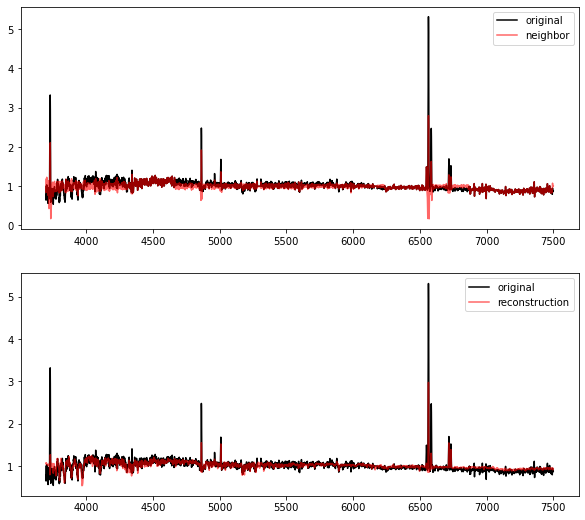

In [268]:
neighbor_id = 12
reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(10, 9))
axs[0].plot(wave, neighbors[0], color="black", label="original")
axs[0].plot(wave, neighbors[neighbor_id], color="red", alpha=0.6, label="neighbor")
# axs[2].plot(wave, reconstruction, color="red", alpha=0.8, label="reconstruction")
axs[1].plot(wave, neighbors[0], color="black", alpha=1, label="original")
axs[1].plot(wave, reconstruction, color="red", alpha=0.6, label="reconstruction")
for ax in axs: ax.legend()
print(number_segments)

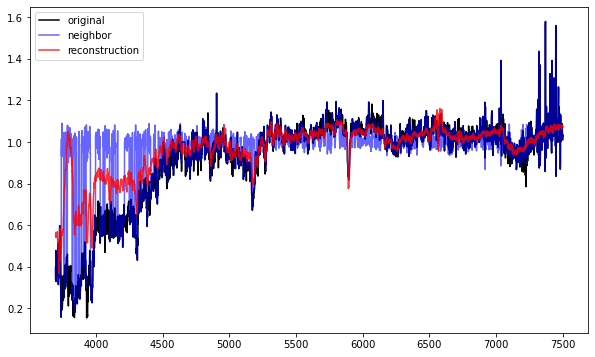

In [35]:
fudge_parameters = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "flat",
# scale
    "scale_factor": 0.01,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 1
}
number_segments = 512

segmenter = SpectraSegmentation()
segmentation_function = segmenter.uniform
# segmentation_function = segmenter.kmeans

segmentation_function = partial(segmentation_function, number_segments=number_segments)

spectrum = spectra[idx_id[100, 0]]

neighbors = neighborhood.get_neighbors(
    fudge_parameters=fudge_parameters,
    spectrum=spectrum,
    segmentation_function=segmentation_function
)
neighbor_id = 2
reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wave, neighbors[0], color="black", label="original")
ax.plot(wave, neighbors[neighbor_id], color="blue", alpha=0.6, label="neighbor")
ax.plot(wave, reconstruction, color="red", alpha=0.8, label="reconstruction")
ax.legend()


In [232]:
fudge_parameters = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "flat",
# scale
    "scale_factor": 2.,
# flat
    "continuum": 1,
# gaussians
    "amplitude":100.,
    "sigmas_in_segment": 2,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0.05
}
# number_segments = wave.size//200
number_segments = 100

segmenter = SpectraSegmentation()
# segmentation_function = segmenter.uniform
segmentation_function = segmenter.kmeans

segmentation_function = partial(segmentation_function, number_segments=number_segments)

spectrum = spectra[idx_id[-2356, 0]]

neighbors = neighborhood.get_neighbors(
    fudge_parameters=fudge_parameters,
    spectrum=spectrum,
    segmentation_function=segmentation_function
)
print(f"pixels per segment: {wave.size/number_segments}")

pixels per segment: 37.76


In [233]:
# # number_segments = wave.size//200
# number_segments = 100
# spectrum = spectra[idx_id[-2356, 0]]

# segmenter = SpectraSegmentation()
# # segmentation_function = segmenter.uniform
# segmentation_function = segmenter.kmeans

# segments = segmentation_function(spectrum, number_segments=number_segments)
# segmented_spectrum = spectrum_in_segments(spectrum, segments)
# print(np.unique(segments).shape)
# for segment in segmented_spectrum:
#     plt.plot(wave, segment)

100


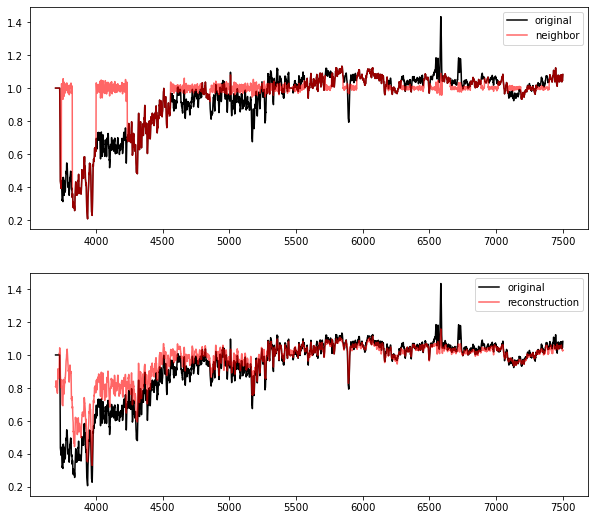

In [243]:
neighbor_id = 9
reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(10, 9))
axs[0].plot(wave, neighbors[0], color="black", label="original")
axs[0].plot(wave, neighbors[neighbor_id], color="red", alpha=0.6, label="neighbor")
# axs[2].plot(wave, reconstruction, color="red", alpha=0.8, label="reconstruction")
axs[1].plot(wave, neighbors[0], color="black", alpha=1, label="original")
axs[1].plot(wave, reconstruction, color="red", alpha=0.6, label="reconstruction")
for ax in axs: ax.legend()
print(number_segments)

In [255]:
fudge_parameters = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":100.,
    "sigmas_in_segment": 2,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0.05
}
# number_segments = wave.size//200
number_segments = 100

segmenter = SpectraSegmentation()
# segmentation_function = segmenter.uniform
segmentation_function = segmenter.kmeans

segmentation_function = partial(segmentation_function, number_segments=number_segments)
idx_spectrum = specobjid_to_idx(531492683672217600, idx_id)
spectrum = spectra[idx_spectrum]

neighbors = neighborhood.get_neighbors(
    fudge_parameters=fudge_parameters,
    spectrum=spectrum,
    segmentation_function=segmentation_function
)
print(f"pixels per segment: {wave.size/number_segments}")

pixels per segment: 37.76


100


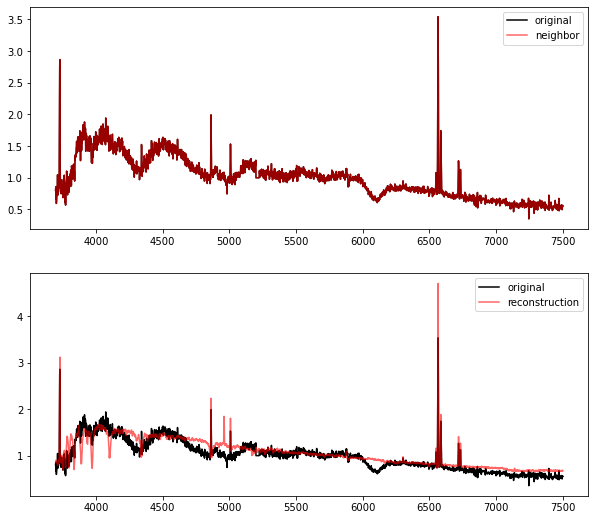

In [257]:
neighbor_id = 0
reconstruction = model.reconstruct(neighbors[neighbor_id]).reshape(-1)
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(10, 9))
axs[0].plot(wave, neighbors[0], color="black", label="original")
axs[0].plot(wave, neighbors[neighbor_id], color="red", alpha=0.6, label="neighbor")
# axs[2].plot(wave, reconstruction, color="red", alpha=0.8, label="reconstruction")
axs[1].plot(wave, neighbors[0], color="black", alpha=1, label="original")
axs[1].plot(wave, reconstruction, color="red", alpha=0.6, label="reconstruction")
for ax in axs: ax.legend()
print(number_segments)

(82, 3776)
(82,)


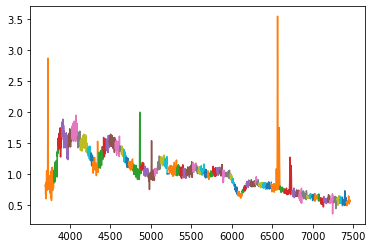

In [249]:
# number_segments = wave.size//200
number_segments = 100
# spectrum = spectra[idx_id[-2356, 0]]

segmenter = SpectraSegmentation()
# segmentation_function = segmenter.uniform
segmentation_function = segmenter.kmeans

segments = segmentation_function(spectrum, number_segments=number_segments)
segmented_spectrum = spectrum_in_segments(spectrum, segments)
print(np.unique(segments).shape)
for segment in segmented_spectrum:
    plt.plot(wave, segment)